In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchsummary import summary
from models.KANFormer import KANFormer
from utils import get_model_size

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# (self,HSI_bands=31,MSI_bands=3,hidden_dim=256,scale=4,depth=4,image_size=64)
myKAN = KANFormer(HSI_bands=31,MSI_bands=3,hidden_dim=256,scale=4,depth=4,image_size=64)
myKAN = myKAN.to(device)
model_dir = './trained_models/CAVEx2_epoch:999,PSNR:54.62.pth'
#model_dir = './trained_models/CAVEx4_epoch:999,PSNR:49.17.pth'
checkpoint = torch.load(model_dir)
myKAN.load_state_dict(checkpoint['net'], strict=False)
# Set for forward use
myKAN.eval()

/tmp/ipykernel_21504/3008780425.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_dir)


KANFormer(
  (fusion): Fusion(
    (hsi_kan): KANLinear(
      (base_activation): SiLU()
    )
    (msi_kan): KANLinear(
      (base_activation): SiLU()
    )
    (align_kan): KANLinear(
      (base_activation): SiLU()
    )
  )
  (layers): ModuleList(
    (0-3): 4 x KANBlock(
      (kan_layer_01): KANLinear(
        (base_activation): SiLU()
      )
      (kan_layer_02): KANLinear(
        (base_activation): SiLU()
      )
    )
  )
  (refine): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [3]:
#from torchinfo import summary
from torchsummary import summary
summary(myKAN,input_size=[(31,16,16),(3,64,64)])

torch.Size([2, 31, 16, 16])
torch.Size([2, 31, 64, 64])
torch.Size([2, 4096, 31]) torch.Size([2, 4096, 3])
lrhsi to first KAN
X.size 31
31
X.shape torch.Size([8192, 31])
Base weight torch.float32
hrmsi to second KAN
X.size 3
3
X.shape torch.Size([8192, 3])
Base weight torch.float32
torch.Size([2, 4096, 256]) torch.Size([2, 4096, 256])
concatenated LR/HR to 3rd KAN
X.size 512
512
X.shape torch.Size([8192, 512])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([2, 256])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([2, 256])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([2, 256])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([2, 256])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([2, 256])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([2, 256])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([2, 256])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([2, 256])
Base weight torch.float32


In [ ]:
model = KANFormer(scale=4,depth=4)
model = model.to(device)
checkpoint = torch.load(model_dir)
model.load_state_dict(checkpoint['net'],strict=False)


In [ ]:
print(model['net']['fusion.hsi_kan.spline_weight'].shape)
print(model['net']['fusion.hsi_kan.base_weight'].shape)
print(model['net']['layers.0.kan_layer_01.spline_weight'].shape)

In [ ]:
summary(model, input_size=[(31,16,16),(3,64,64)])

# Fuse mock data


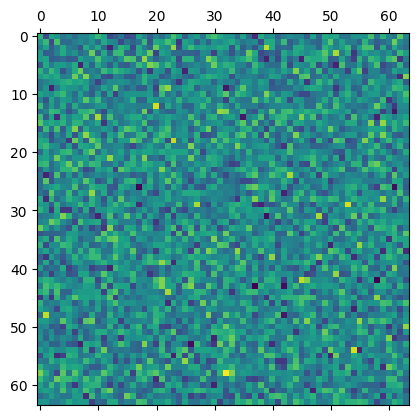

In [4]:
gt = np.random.binomial(100,0.7,size=((64,64,31)))
plt.matshow(gt[:,:,0])

dtype('float64')

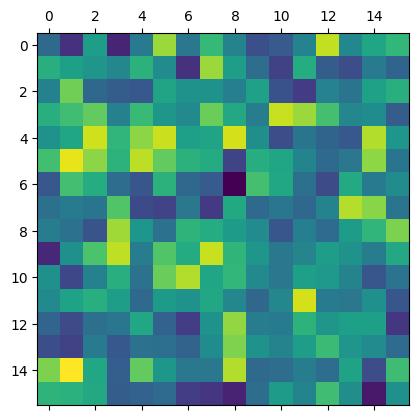

In [5]:
from skimage.transform import resize
from skimage.measure import block_reduce

lr_hs = resize(gt, (16, 16, 31), anti_aliasing=True)
plt.matshow(lr_hs[:,:,0])
lr_hs = lr_hs.reshape(1,31,16,16)
lr_hs.dtype


In [6]:
hr_ms = gt.reshape((1,31,64,64))[:,:3,:,:].astype(np.float64)
hr_ms.shape

(1, 3, 64, 64)

In [7]:
print(hr_ms.dtype)
print(lr_hs.dtype)

float64
float64


In [10]:
print(lr_hs.shape,hr_ms.shape)
print(torch.tensor(lr_hs).shape)
lr_hs_torch = torch.tensor(lr_hs, dtype=torch.float32).to(device)
hr_ms_torch = torch.tensor(hr_ms, dtype=torch.float32).to(device)
print(hr_ms_torch.dtype)
print(lr_hs_torch.dtype)

(1, 31, 16, 16) (1, 3, 64, 64)
torch.Size([1, 31, 16, 16])
torch.float32
torch.float32


In [15]:
fused = myKAN.forward(lr_hs_torch,hr_ms_torch)

torch.Size([1, 31, 16, 16])
torch.Size([1, 31, 64, 64])
torch.Size([1, 4096, 31]) torch.Size([1, 4096, 3])
lrhsi to first KAN
X.size 31
31
X.shape torch.Size([4096, 31])
Base weight torch.float32
hrmsi to second KAN
X.size 3
3
X.shape torch.Size([4096, 3])
Base weight torch.float32
torch.Size([1, 4096, 256]) torch.Size([1, 4096, 256])
concatenated LR/HR to 3rd KAN
X.size 512
512
X.shape torch.Size([4096, 512])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([1, 256])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([1, 256])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([1, 256])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([1, 256])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([1, 256])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([1, 256])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([1, 256])
Base weight torch.float32
X.size 256
256
X.shape torch.Size([1, 256])
Base weight torch.float32


In [21]:
fused_image = fused.cpu().detach().numpy()
print(fused_image.shape)
print(type(fused_image))


(1, 31, 64, 64)
<class 'numpy.ndarray'>


(64, 64, 31, 1)


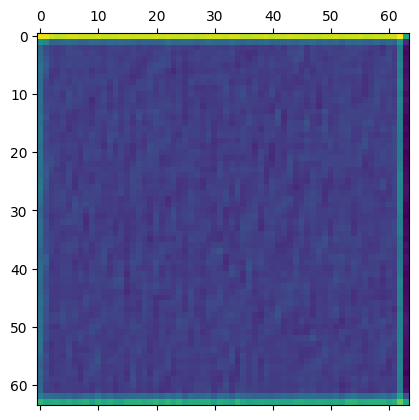

In [26]:
from einops import rearrange
fused_image = rearrange(fused_image,'b c h w -> h w c b')
print(fused_image.shape)
plt.matshow(fused_image[:,:,0,0])

In [28]:
from utils import Metric
metric = Metric(gt,fused_image.squeeze(-1))

metric.calc_rmse()

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

## Format CAVE data